# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

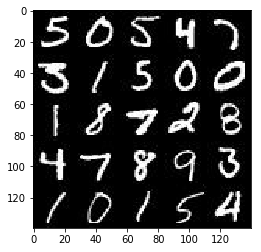

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

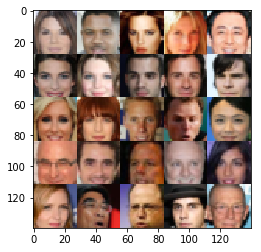

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_images")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    

    return (input_images, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(x, x*alpha)
    
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        #images (input): 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding="same")
        x1 = leaky_relu(x1)
        #x1: 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2)
        #x2: 7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, 2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3)
        #x3: 4x4x256
        
        flattened = tf.reshape(x3, shape=(-1, 256*4*4))
        logits = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logits)


    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(x, x*alpha)
    
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        z_dense = tf.layers.dense(z, 4*4*512)
        z_reshaped = tf.reshape(z_dense, (-1, 4,4,512))
        z_batch_norm = tf.layers.batch_normalization(z_reshaped, training=is_train)
        # shape = 4x4x512
        
        x1 = tf.layers.conv2d_transpose(z_batch_norm, 256, 4, 1, padding="valid")
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # shape = 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, 2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # shape = 14x14x128
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, 2, padding="same")
        # shape = 28x28x out_channel_dim

        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # NB: es müssen die label für das training des generators umgedreht werden!
    # für den Diskriminator sind alle fake Bilder vom Generator False und alle echten Bilder True
    # für den Generator sind alle Antworten vom Diskriminator, als Fake identifizert wurden, True
    
    label_smoothing = 0.1
    
    # create model returns:
    g_model = generator(input_z, out_channel_dim)
    (d_model_out_real, d_model_logits_real) = discriminator(input_real)
    (d_model_out_fake, d_model_logits_fake) = discriminator(g_model, reuse=True)
    
    g_model_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_model_logits_fake, labels=tf.ones_like(d_model_logits_fake))
    )
    
    d_model_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_model_logits_fake, labels=tf.zeros_like(d_model_logits_fake))
    ) 
    d_model_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_model_logits_real, labels=tf.ones_like(d_model_logits_real)*(1 - label_smoothing))
    )
    
    d_model_loss = d_model_loss_fake + d_model_loss_real
    
    return (d_model_loss, g_model_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    descriminator_vars = [x for x in trainable_vars if x.name.startswith("discriminator")]
    generator_vars = [x for x in trainable_vars if x.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        descriminator_training_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            d_loss, var_list=descriminator_vars
        )
        generator_training_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            g_loss, var_list=generator_vars
        )
        
    
    return (descriminator_training_optimizer, generator_training_optimizer)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_loss_every = 10
    show_images_every = 100
    n_images = 25
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    ph_input_real, ph_input_z, ph_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_model_loss, g_model_loss = model_loss(ph_input_real, ph_input_z, image_channels)
    d_optimizer, g_optimizer = model_opt(d_model_loss, g_model_loss, ph_learning_rate, beta1)
    nof_batches = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                nof_batches += 1
                
                # TODO: Train Model
                
                batch_images = batch_images * 2.0
                input_z_data = np.random.uniform(-1,1, size=(batch_size, z_dim) )
                                                 
                sess.run(d_optimizer,
                         feed_dict={
                            ph_input_real: batch_images,
                            ph_input_z: input_z_data,
                            ph_learning_rate: learning_rate
                         }
                )
                                                 
                sess.run(g_optimizer, 
                         feed_dict={
                            ph_input_real: batch_images,
                            ph_input_z: input_z_data,
                            ph_learning_rate: learning_rate
                         }
                )
                
                if nof_batches % print_loss_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    _ = train_loss_d = d_model_loss.eval({
                        ph_input_real: batch_images, 
                        ph_input_z: input_z_data
                    })
                    _ = train_loss_g = g_model_loss.eval({
                        ph_input_z: input_z_data
                    })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                
                if nof_batches % show_images_every == 0:
                    show_generator_output(sess, n_images, ph_input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 1.9639
Epoch 1/2... Discriminator Loss: 1.6903... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 1.5986... Generator Loss: 1.7310
Epoch 1/2... Discriminator Loss: 1.8355... Generator Loss: 0.3975
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 1.8141
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.4348
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.5592
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 1.4672


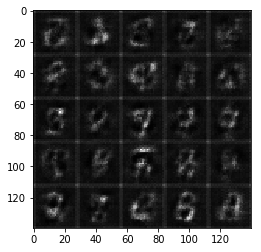

Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.0373... Generator Loss: 1.5466
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 2.0262


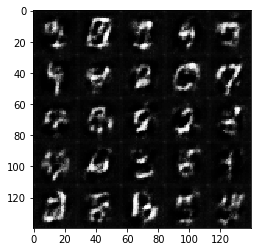

Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 1.3403
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.4030
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 2.1920
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 1.7882
Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 1.5201
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 3.0506
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 1.9470


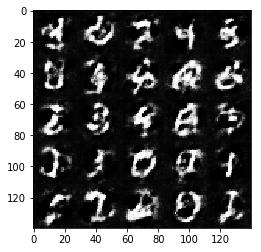

Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 2.7180
Epoch 1/2... Discriminator Loss: 1.2153... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 2.0759
Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 1.5083
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.5704
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 1.1077
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.0081


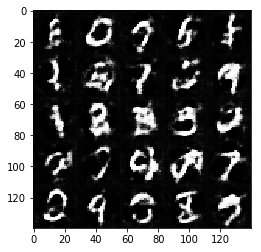

Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.5442
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 1.2671
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 2.1285
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 0.8187... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 1.0539


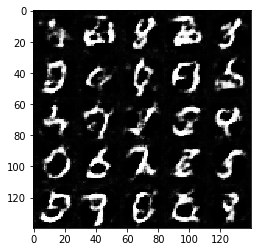

Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 1.8619
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 1.9213
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 1.7021
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 1.9258
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.4226
Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 2.1447
Epoch 1/2... Discriminator Loss: 0.9097... Generator Loss: 0.9932


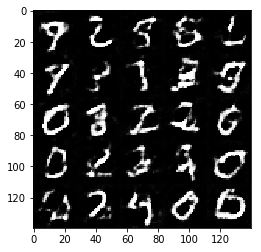

Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 1.4183
Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.7316
Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.7284
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.1993
Epoch 2/2... Discriminator Loss: 3.6497... Generator Loss: 4.9822
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.1597
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 2.8084


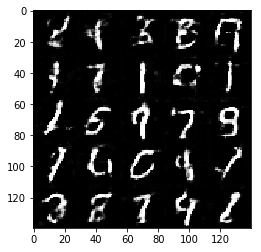

Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.4233
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 0.9725
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 2.5822
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.1014
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 2.3152
Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.7974
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 2.0248


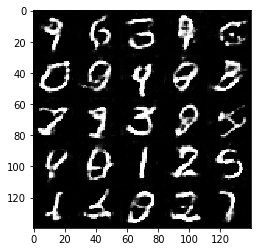

Epoch 2/2... Discriminator Loss: 1.4323... Generator Loss: 2.6972
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 0.9775
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.4640
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.3345
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.6582
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.2061
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.7133
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.2761
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.2936
Epoch 2/2... Discriminator Loss: 4.9620... Generator Loss: 6.5608


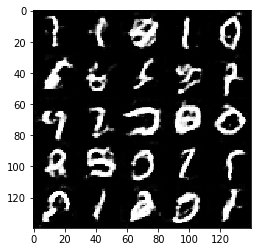

Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.0430
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.8558
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.7372
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.2859
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.3160
Epoch 2/2... Discriminator Loss: 0.8606... Generator Loss: 0.9889
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 0.6973... Generator Loss: 1.3962
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.0442


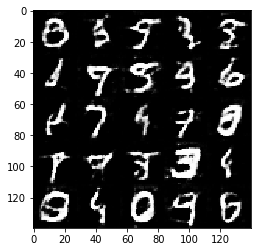

Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.5278
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 1.7483
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.5268
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.0908
Epoch 2/2... Discriminator Loss: 1.5494... Generator Loss: 0.4533
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.4443
Epoch 2/2... Discriminator Loss: 1.7542... Generator Loss: 3.4585
Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.9575


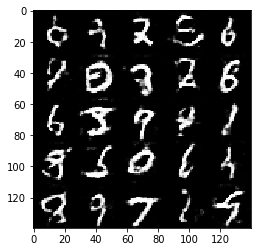

Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.1737
Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 1.6129
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.9105
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 1.6702
Epoch 2/2... Discriminator Loss: 0.6824... Generator Loss: 1.8060
Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.7207
Epoch 2/2... Discriminator Loss: 1.1627... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 2.0725
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.8926


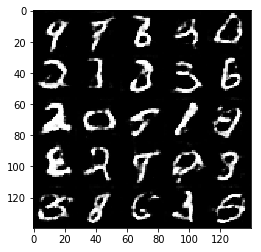

In [17]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 2.1851
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 2.2313
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.7357
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7068


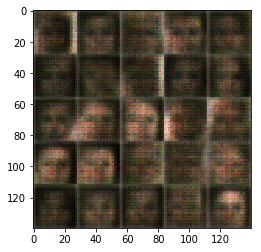

Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.8763
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.5516
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 2.0944
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7797


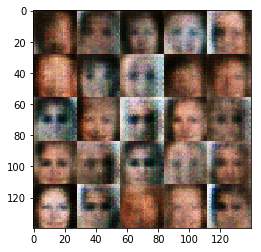

Epoch 1/1... Discriminator Loss: 1.8466... Generator Loss: 2.7631
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.7756... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.2492


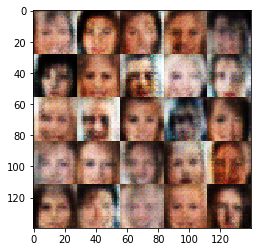

Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9769


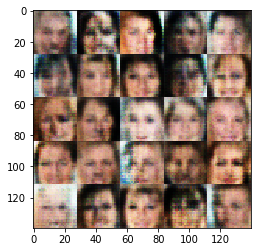

Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.7251... Generator Loss: 0.3621
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4953


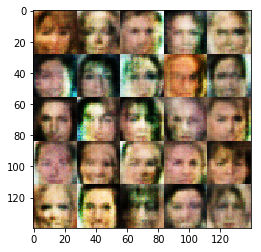

Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.5149


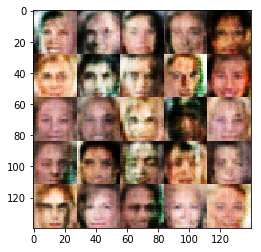

Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 1.3320
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 1.6626
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.4041


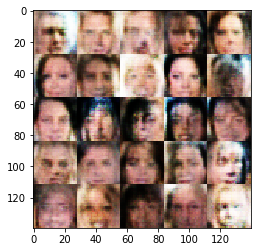

Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.6091
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.9944


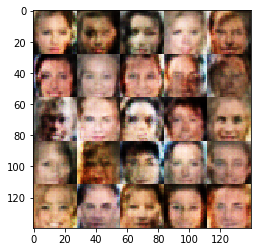

Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.4336


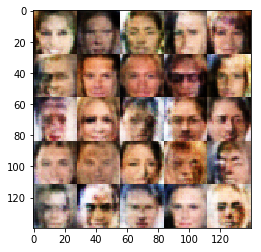

Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.9288
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.9020


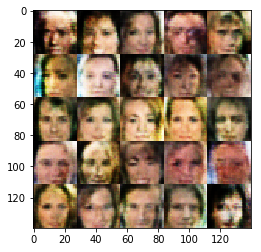

Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 2.1862
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.0129


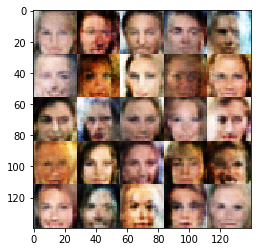

Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.6165
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 3.1826
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.5688


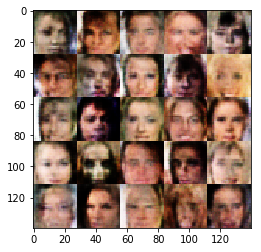

Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.7042
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 4.3250
Epoch 1/1... Discriminator Loss: 1.6608... Generator Loss: 3.9238
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 2.8679
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.8009


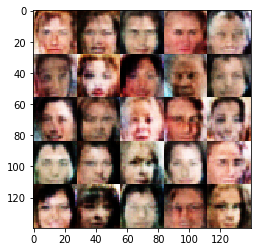

Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.5126
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.7482
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.8473
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 2.3996
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 2.5492
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 2.4829
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.3601
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.8487
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 5.9242


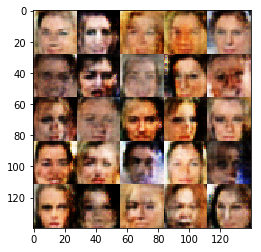

Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.6429
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.4963
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 3.3459
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 4.3469
Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 2.3970
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 2.4733
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 5.8621
Epoch 1/1... Discriminator Loss: 1.9108... Generator Loss: 8.3890
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.4779
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 3.9065


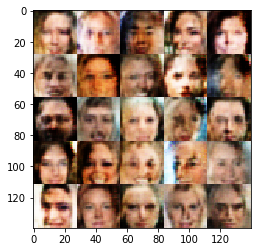

Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.5145
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 4.3414
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 4.4785
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 4.2229


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print(celeba_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.